In [1]:
# download the names.txt file from github
#!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [19]:
import torch
import matplotlib.pyplot as plt # for making figures
import torch.nn.functional as F
import time
import random

In [3]:
'''# 1. Check if the MPS backend is available
if torch.backends.mps.is_available():
    # 2. Set the default device to 'mps'
    torch.set_default_device('mps')
    print("Default device has been set to 'mps' (Mac GPU)")
else:
    # Fallback to CPU if MPS is not available
    print("MPS not available. Default device remains 'cpu'.")'''

'# 1. Check if the MPS backend is available\nif torch.backends.mps.is_available():\n    # 2. Set the default device to \'mps\'\n    torch.set_default_device(\'mps\')\n    print("Default device has been set to \'mps\' (Mac GPU)")\nelse:\n    # Fallback to CPU if MPS is not available\n    print("MPS not available. Default device remains \'cpu\'.")'

In [20]:
torch.set_default_device('cpu')
print("Default device has been set to 'cpu'")

Default device has been set to 'cpu'


In [21]:
#get all words from names.txt
words = open('data/names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [22]:
#get all the unique characters in the words
chars = sorted(list(set(''.join(words))))
print(chars)

# create a mapping from characters to integers
stoi = {ch:i+1 for i, ch in enumerate(chars)}
itos = {i+1:ch for i, ch in enumerate(chars)}
stoi['.'] = 0
itos[0] = '.'
vocab_size = len(itos)
print(stoi)
print(itos)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [23]:
block_size = 10

#build the dataset
def build_dataset(words):
    X, Y = [], []
    for word in words:
        context = [0]
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            context = context[1:] + [ix]
            Y.append(context)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    
    return (X, Y)
def build_dataset_gpt(words):
    data = []
    for word in words:
        context = [0] * block_size
        for ch in word:
            ix = stoi[ch]
            data.append(context)
            context = context[1:] + [ix]
    data = torch.tensor(data)
    print(data.shape)
    return data

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

random.shuffle(words)


train_data, train_targets  = build_dataset(words[:n1])     # 80%
val_data, val_targets = build_dataset(words[n1:n2])   # 10%
test_data, test_targets  = build_dataset(words[n2:])     # 10%

torch.Size([182436, 1]) torch.Size([182436, 1])
torch.Size([22908, 1]) torch.Size([22908, 1])
torch.Size([22802, 1]) torch.Size([22802, 1])


In [24]:
batch_size = 64
max_iters = 5000
learning_rate = 1e-4
n_embd = 35
n_head = 5
n_layer = 5
n_input = block_size * n_embd
n_output = vocab_size

history_loss = []

In [25]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    if split == 'train':
        data = train_data
        targets = train_targets
    else:
        data = val_data
        targets = val_targets
    ix = torch.randint(0, data.shape[0], (batch_size,))
    x = data[ix]
    y = targets[ix]
    return x, y

In [26]:
x, y = get_batch('train')
print(x[:5])
print(y[:5])

tensor([[14],
        [ 4],
        [ 9],
        [ 5],
        [ 0]])
tensor([[20],
        [ 5],
        [25],
        [ 0],
        [10]])


In [11]:
#Sequential model
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def append(self, layer):
        self.layers.append(layer)

#Embedding layer
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.weight = torch.randn(num_embeddings, embedding_dim)

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]

#Linear layer
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.fan_in = fan_in
        self.fan_out = fan_out
        self.weight = torch.randn(fan_in, fan_out)/fan_in**0.5 #kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#Tanh activation function
class Tanh:
    def __init__(self):
        pass
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

#softmax activation function
class Softmax:
    def __init__(self, dim = 1):
        self.dim = dim
    def __call__(self, x):
        self.out = torch.softmax(x, dim=self.dim)
        return self.out
    def parameters(self):
        return []

#ReLU activation function
class ReLU:
    def __init__(self):
        pass
    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out
    def parameters(self):
        return []

#Flatten layer
class Flatten:
    def __init__(self, start_dim=1, end_dim=-1):
        self.start_dim = start_dim
        self.end_dim = end_dim
    def __call__(self, x):
        #(d_1, d_2, ..., d_n) -> (d_1, d_2*...*d_)
        shape = list()
        if self.end_dim == -1:
            for i, dim in enumerate(x.shape):
                if (i <= self.start_dim) or (len(shape) == 0):
                    shape.append(dim)
                else:
                    shape[-1] *= dim
        else:
            for i, dim in enumerate(x.shape):
                if (i <= self.start_dim) or (len(shape) == 0):
                    shape.append(dim)
                elif i > self.end_dim:
                    shape.append(dim)
                else:
                    shape[-1] *= dim
        self.out = x.view(shape)
        return self.out
    def parameters(self):
        return []

#Vanila RNN layer
class RNN:
    def __init__(self, n_input, n_hidden):
        self.n_input = n_input
        self.n_hidden = n_hidden
        #self.non_linearity = non_linearity
        self.W_xh = torch.randn(n_input, n_hidden) / n_input**0.5 #kaiming initialization
        self.W_hh = torch.randn(n_hidden, n_hidden) / n_hidden**0.5 #kaiming initialization
        self.b_h = torch.zeros(n_hidden)
        
    def __call__(self, x):
        #(N, L, H_in) -> (N, L, H_out)
        #h_t -> (N, H_out)
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.n_hidden)
        output = []
        for i in range(seq_len):
            h_t = torch.tanh(x[:, i, :] @ self.W_xh + h_t @ self.W_hh + self.b_h)
            output.append(h_t)

        self.h = torch.stack(output, dim=1)
        return self.h
    def parameters(self):
        return [self.W_xh, self.W_hh, self.b_h]

#LSTM layer
class LSTM:
    def __init__(self, n_input, n_hidden):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.W_ii = torch.randn(n_input, n_hidden) / n_input**0.5 #kaiming initialization
        self.W_hi = torch.randn(n_hidden, n_hidden) / n_hidden**0.5 #kaiming initialization
        self.b_i = torch.zeros(n_hidden)
        
        self.W_if = torch.randn(n_input, n_hidden) / n_input**0.5 #kaiming initialization
        self.W_hf = torch.randn(n_hidden, n_hidden) / n_hidden**0.5 #kaiming initialization
        self.b_f = torch.zeros(n_hidden)
        
        self.W_ig = torch.randn(n_input, n_hidden) / n_input**0.5 #kaiming initialization
        self.W_hg = torch.randn(n_hidden, n_hidden) / n_hidden**0.5 #kaiming initialization
        self.b_g = torch.zeros(n_hidden)
        
        self.W_io = torch.randn(n_input, n_hidden) / n_input**0.5 #kaiming initialization
        self.W_ho = torch.randn(n_hidden, n_hidden) / n_hidden**0.5 #kaiming initialization
        self.b_o = torch.zeros(n_hidden)

        
    def __call__(self, x):
        #(N, L, H_in) -> (N, L, H_out)
        #h_t -> (N, H_out)
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.n_hidden)
        c_t = torch.zeros(batch_size, self.n_hidden)
        output = []
        for i in range(seq_len):
            i_t = torch.sigmoid(x[:, i, :] @ self.W_ii + h_t @ self.W_hi + self.b_i)
            f_t = torch.sigmoid(x[:, i, :] @ self.W_if + h_t @ self.W_hf + self.b_f)
            g_t = torch.tanh(x[:, i, :] @ self.W_ig + h_t @ self.W_hg + self.b_g)
            o_t = torch.sigmoid(x[:, i, :] @ self.W_io + h_t @ self.W_ho + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            output.append(h_t)
        self.h = torch.stack(output, dim=1)
        self.c = c_t
        return self.h
    def parameters(self):
        return [self.W_ii, self.W_hi, self.b_i, self.W_if, self.W_hf, self.b_f, self.W_ig, self.W_hg, self.b_g, self.W_io, self.W_ho, self.b_o]

#GRU layer
class GRU:
    def __init__(self, n_input, n_hidden):
        self.n_input = n_input
        self.n_hidden = n_hidden
        
        self.W_ir = torch.randn(n_input, n_hidden) / n_input**0.5 #kaiming initialization
        self.W_hr = torch.randn(n_hidden, n_hidden) / n_hidden**0.5 #kaiming initialization
        self.b_r = torch.zeros(n_hidden)
        
        self.W_iz = torch.randn(n_input, n_hidden) / n_input**0.5 #kaiming initialization
        self.W_hz = torch.randn(n_hidden, n_hidden) / n_hidden**0.5 #kaiming initialization
        self.b_z = torch.zeros(n_hidden)
        
        self.W_in = torch.randn(n_input, n_hidden) / n_input**0.5 #kaiming initialization
        self.W_hn = torch.randn(n_hidden, n_hidden) / n_hidden**0.5 #kaiming initialization
        self.b_in = torch.zeros(n_hidden)
        self.b_hn = torch.zeros(n_hidden)
    
    def parameters(self):
        return [self.W_ir, self.W_hr, self.b_r, self.W_iz, self.W_hz, self.b_z, self.W_in, self.W_hn, self.b_in, self.b_hn]
    
    def __call__(self, x):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.n_hidden)
        output = []
        
        for i in range(seq_len):
            r_t = torch.sigmoid(x[:, i, :] @ self.W_ir + h_t @ self.W_hr + self.b_r)
            z_t = torch.sigmoid(x[:, i, :] @ self.W_iz + h_t @ self.W_hz + self.b_z)
            n_t = torch.tanh(x[:, i, :] @ self.W_in + self.b_in + r_t * (h_t @ self.W_hn + self.b_hn))
            h_t = (1 - z_t) * n_t + z_t * h_t
            output.append(h_t)
        self.h = torch.stack(output, dim=1)
        
        return self.h

#Batch normalization
class BatchNorm1d:
    def __init__(self, num_features, eps=1e-5, momentum=0.1, training=True):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.training = training
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            x_mean = x.mean(dim=dim, keepdim=True)
            x_var = x.var(dim=dim, keepdim=True)
            with torch.no_grad():
                self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * x_mean
                self.running_var = self.momentum * self.running_var + (1 - self.momentum) * x_var
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_std = torch.sqrt(x_var + self.eps)
        x_hat = (x - x_mean) / x_std
        self.out = x_hat * self.gamma + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

#Layer normalization
class LayerNorm:
    def __init__(self, normalized_shape, eps=1e-5):
        self.num_features = normalized_shape
        self.eps = eps
        self.gamma = torch.ones(normalized_shape)
        self.beta = torch.zeros(normalized_shape)
        
    def __call__(self, x):
        x_mean = x.mean(dim=-1, keepdim=True)
        x_var = x.var(dim=-1, keepdim=True, unbiased=False)
        self.out = (x - x_mean) / torch.sqrt(x_var + self.eps) * self.gamma + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


In [12]:
#SGD optimizer
class SGD:
    def __init__(self, parameters, lr=0.001, momentum=0):
        self.parameters = parameters
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in parameters]
        #self.dampening = dampening
        #self.weight_decay = weight_decay
    
    def zero_grad(self):
        for p in self.parameters:
            p.grad = None
        
    def step(self):
        for (i, p) in enumerate(self.parameters):
            if p.grad is not None:
                self.v[i] = self.momentum * self.v[i] + (1 - self.momentum) * p.grad
                p.data -= self.lr * self.v[i]

#Adam optimizer
class Adam:
    def __init__(self, parameters, lr = 0.001, betas = (0.9, 0.999), eps = 1e-8):
        self.parameters = parameters
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.m = [torch.zeros_like(p) for p in parameters]
        self.v = [torch.zeros_like(p) for p in parameters]
        self.t = 0
        
    def zero_grad(self):
        for p in self.parameters:
            p.grad = None
    
    def step(self):
        self.t += 1
        for (i, p) in enumerate(self.parameters):
            if p.grad is not None:
                self.m[i] = self.betas[0] * self.m[i] + (1 - self.betas[0]) * p.grad
                self.v[i] = self.betas[1] * self.v[i] + (1 - self.betas[1]) * p.grad**2
                m_hat = self.m[i] / (1 - self.betas[0]**self.t)
                v_hat = self.v[i] / (1 - self.betas[1]**self.t)
                p.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

In [13]:
#Residual block
class ResidualBlock():
    def __init__(self, n_hidden):
        self.linear1 = Linear(n_hidden, n_hidden, bias=False)
        self.linear2 = Linear(n_hidden, n_hidden, bias=True)
        self.relu = ReLU()
        self.batchnorm = BatchNorm1d(n_hidden)

    def __call__(self, x):
        input = x
        x = self.linear1(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.linear2(x)
        return input + x #residual connection
    def parameters(self):
        return self.linear1.parameters() + self.linear2.parameters() + self.batchnorm.parameters()
    
#TakeLayer
class TakeLayer:
    def __init__(self, index):
        self.index = index

    def __call__(self, x):
        return x[:, self.index, :]
    
    def parameters(self):
        return []

#SelfAttention layer
class SelfAttention:
    def __init__(self, n_embd, head_size):
        self.n_embd = n_embd
        self.head_size = head_size
        self.query = Linear(n_embd, head_size, bias=False)
        self.key = Linear(n_embd, head_size, bias=False)
        self.value = Linear(n_embd, head_size, bias=False)

    def parameters(self):
        return self.query.parameters() + self.key.parameters() + self.value.parameters()
    
    def __call__(self, x):
        #input shape: (N, L, H_in)
        #output shape: (N, L, H_out)
        N, L, _ = x.size()
        H_out = self.head_size
        q = self.query(x) #(N, L, H_out)
        k = self.key(x) #(N, L, H_out)
        v = self.value(x) #(N, L, H_out)
        
        wei = q @ k.transpose(-2, -1) * H_out**-0.5 #(N, L, L)
        tril = torch.tril(torch.ones(L, L)) #(L, L)
        wei = wei.masked_fill(tril == 0, float('-inf')) #(N, L, L)
        wei = F.softmax(wei, dim=-1) #(N, L, L)
        
        out = wei @ v #(N, L, H_out)
        return out
    
    def parameters(self):
        return self.query.parameters() + self.key.parameters() + self.value.parameters()

#MultiHeadAttention layer
class MultiHeadAttention:
    def __init__(self, n_embd, head_size, n_heads):
        self.n_embd = n_embd
        self.head_size = head_size
        self.n_heads = n_heads
        self.heads = [SelfAttention(n_embd, head_size) for _ in range(n_heads)]
        self.project = Linear(head_size * n_heads, n_embd)
    
    def parameters(self):
        return [param for head in self.heads for param in head.parameters()] + self.project.parameters()
    
    def __call__(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.project(out)
        return out
    
#FeedForward layer
class FeedForward:
    def __init__(self, n_embd):
        self.n_embd = n_embd
        self.net = Sequential(
            [
            Linear(n_embd, 4*n_embd, bias=True),
            ReLU(),
            Linear(4*n_embd, n_embd, bias=True)
            ]
        )
    
    def parameters(self):
        return self.net.parameters()
    
    def __call__(self, x):
        return self.net(x)

#ResidualTransformerBlock
class ResidualTransformerBlock:
    def __init__(self, n_embd, n_head):
        self.n_embd = n_embd
        head_size = n_embd // n_head
        self.n_head = n_head
        self.attention = MultiHeadAttention(n_embd, head_size, n_head)
        self.norm1 = LayerNorm(n_embd)
        self.feedforward = FeedForward(n_embd)
        self.norm2 = LayerNorm(n_embd)
    
    def parameters(self):
        return self.attention.parameters() + self.norm1.parameters() + self.norm2.parameters() + self.feedforward.parameters()
    
    def __call__(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.feedforward(self.norm2(x))
        return x
    
#Token + position embedding
class TokenEmbedding:
    def __init__(self, vocab_size, n_embd):
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.token_embedding_table = Embedding(vocab_size, n_embd)
        self.position_embedding_table = Embedding(block_size, n_embd)

    def parameters(self):
        return self.token_embedding_table.parameters() + self.position_embedding_table .parameters()
    
    def __call__(self, idx):
        B, T = idx.shape
        
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)

        return tok_emb + pos_emb
    
class GPT:
    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size):
        self.token_embedding = TokenEmbedding(vocab_size, n_embd)
        self.lm_head = Linear(n_embd, vocab_size)
        self.transformer_blocks = Sequential([ResidualTransformerBlock(n_embd, n_head) for _ in range(n_layer)])
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.n_head = n_head
        self.n_layer = n_layer
    
    def parameters(self):
        return self.token_embedding.parameters() + self.lm_head.parameters() + self.transformer_blocks.parameters()
    
    def __call__(self, idx, targets=None):
        x = self.token_embedding(idx)
        x = self.transformer_blocks(x)
        x = self.lm_head(x)
        
        if targets is None:
            loss = None
        else:
            B, T, C = x.shape
            x = x.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(x, targets)
        return (x, loss)
    

In [14]:
#define the model
'''model = Sequential(
    [TokenEmbedding(vocab_size, n_embd),
    ResidualTransformerBlock(n_embd, n_head),
    ResidualTransformerBlock(n_embd, n_head),
    ResidualTransformerBlock(n_embd, n_head),
    LayerNorm(n_embd),
    Linear(n_embd, vocab_size, bias=True),
    TakeLayer(-1),
    ]
)'''
model = GPT(vocab_size, n_embd, n_head, n_layer, block_size)

In [15]:
for p in model.parameters():
    p.requires_grad = True

In [16]:
optimizer = Adam(model.parameters())

In [17]:
optimizer.lr = learning_rate

In [18]:
start_time = time.time()
for iter in range(max_iters):
    x_batch, y_batch = get_batch('train')
    
    logits, loss = model(x_batch, y_batch)

    #backward pass
    optimizer.zero_grad()
    loss.backward()

    #update the parameters
    optimizer.step()
    
    history_loss.append(loss.log10().item())
        
    if iter % 1000 == 0:
        print(f"iter {iter}, loss {loss.item()}")

end_time = time.time()
elapsed_time = end_time - start_time

print(f"The for loop took {elapsed_time:.4f} seconds to run.")


iter 0, loss 7.697058200836182
iter 1000, loss 1.2662808895111084
iter 2000, loss 1.2664010524749756


KeyboardInterrupt: 

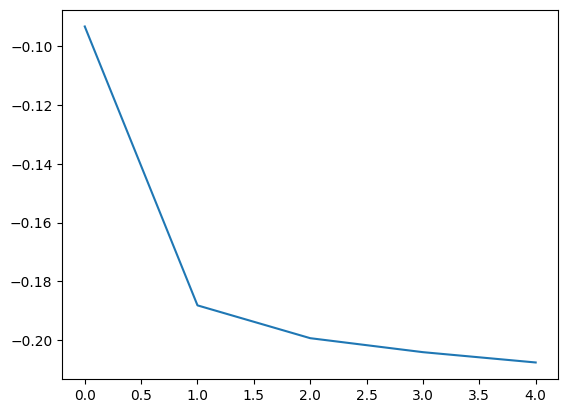

In [ ]:
plt.plot(torch.tensor(history_loss).view(-1, 1000).mean(1))

Small batch:


MPS time: 25.2170 seconds 

CPU time: 5.1533 seconds


Big batch:

MPS time: 39.9550 seconds 

CPU time: 26.8415 seconds


The biggest batch (small loop):

MPS time: 38.4508 seconds 

CPU time: 21.8074 seconds

In [ ]:
#model.layers[3].training = True

: 

In [ ]:
#train loss
logits, _ = model(train_data, None)
loss = F.cross_entropy(logits[:, -1, :], train_targets[:, -1])
print(f"Train loss: {loss.item()}")

#validation
logits, _ = model(val_data, None)
loss = F.cross_entropy(logits[:, -1, :], val_targets[:, -1])
print(f"Validation loss: {loss.item()}")

SGD:

Train loss: 2.062329053878784

Validation loss: 2.1204097270965576

Adam:

1 hidden layer:

Train loss: 2.0225372314453125

Validation loss: 2.1021244525909424

2 hidden layers:

Train loss: 2.1282734870910645

Validation loss: 2.15704607963562

Residual layer:

Train loss: 2.072701930999756

Validation loss: 2.1089556217193604

Vanila RNN:

Train loss: 2.015709161758423

Validation loss: 2.1081628799438477

LSTM:

Train loss: 1.98944091796875

Validation loss: 2.0500173568725586

GRU:

Train loss: 1.834752082824707

Validation loss: 2.0203657150268555

1 Self attention:

Train loss: 2.8630714416503906

Validation loss: 2.865368127822876

Multihead attention + FF:

Train loss: 2.530355930328369

Validation loss: 2.532259464263916

Multihead attention + FF + LayerNorm:

Train loss: 2.2954459190368652

Validation loss: 2.304565906524658

Multihead attention + FF + LayerNorm + Residual:

Train loss: 2.268521547317505

Validation loss: 2.272268533706665

Multiple Multihead attention + FF + LayerNorm + Residual:

Train loss: 2.203157663345337

Validation loss: 2.218388080596924

Everything from above + position embedding
Train loss: 2.15106463432312

Validation loss: 2.182623863220215


In [ ]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits, _ = model(torch.tensor([context]))
      logits = logits[0, -1, :]
      probs = F.softmax(logits, dim=-1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

zersay.
natleli.
belaredn.
jishaseh.
lynona.
anann.
aumarin.
anaita.
kynatii.
riyann.
yasahah.
sexly.
nelianga.
eryda.
zaten.
tashni.
animitoli.
isvha.
vihasfien.
ronian.
